In [ ]:
import jax.numpy as np
from jax import vmap, jit
from jax.lax import scan
from jax.ops import index, index_update

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

In [ ]:
degree = 8
n = 512
bounds = (-1.0, 1.0)
X = np.linspace(bounds[0], bounds[1], n)

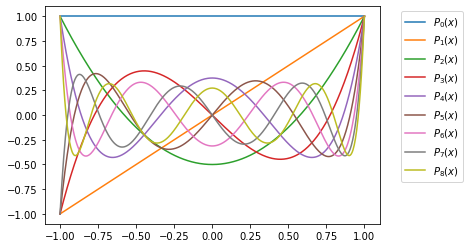

In [ ]:
# Naive implementation
def legendre_naive(X, degree, bounds=(-1.0,1.0)):
    lb, ub = bounds
    X = (2.0*X - lb - ub)/(ub - lb)
    B = np.zeros((n, degree+1))
    B = index_update(B, index[:, 0], np.ones_like(X))
    B = index_update(B, index[:, 1], X)
    for i in range(1, degree+1):
        rec = ((2.0*i+1)*X*B[:,i] - i*B[:,i-1])/(i+1.0)
        B = index_update(B, index[:, i+1], rec)
    return B

B = legendre_naive(X, degree, bounds)
plt.figure()
for i in range(degree+1):
    plt.plot(X, B[:,i], label='$P_{%d}(x)$'%(i))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
%time B = legendre_naive(X, degree, bounds).block_until_ready()

CPU times: user 48.9 ms, sys: 0 ns, total: 48.9 ms
Wall time: 50.3 ms


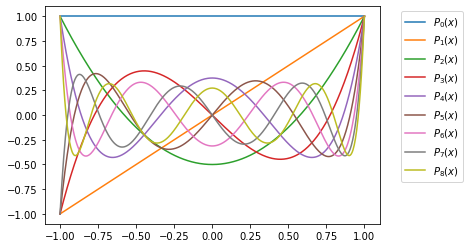

In [ ]:
# Implementation via lax.scan
def legendre_1d(X, degree, bounds=(-1.0,1.0)):
    lb, ub = bounds
    X = (2.0*X - lb - ub)/(ub - lb)
    B = np.zeros((n, degree+1))
    B = index_update(B, index[:, 0], np.ones_like(X))
    B = index_update(B, index[:, 1], X)
    def body_fn(carry, i):
        B, X = carry
        rec = ((2.0*i+1)*X*B[:,i] - i*B[:,i-1])/(i+1.0)
        B = index_update(B, index[:, i+1], rec)
        return (B, X), None
    (B, _), _ = scan(body_fn, (B, X), np.arange(1, degree+1))
    return B

B = legendre_1d(X, degree, bounds)
plt.figure()
for i in range(degree+1):
    plt.plot(X, B[:,i], label='$P_{%d}(x)$'%(i))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
%time B = legendre_1d(X, degree, bounds).block_until_ready()

CPU times: user 106 ms, sys: 2.09 ms, total: 109 ms
Wall time: 110 ms


In [ ]:
# 2D
degree = 5
n = 64
bounds = ((-1.0,1.0), (-1.0, 1.0))
X = np.linspace(bounds[0][0], bounds[0][1], n)
Y = np.linspace(bounds[1][0], bounds[1][1], n)

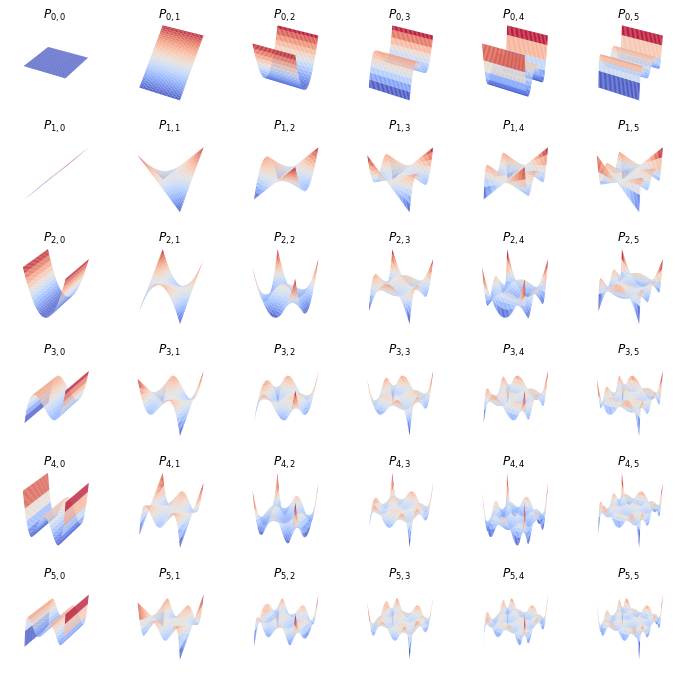

In [ ]:
# In 2D
def legendre_2d(X, Y, degree, bounds):
    nx = X.shape[0]
    ny = Y.shape[0]
    Bx = legendre_1d(X, degree, bounds[0])
    By = legendre_1d(Y, degree, bounds[1])
    B = np.einsum('ik,jl->ijkl', Bx, By)
    return B

B = legendre_2d(X, X, degree, bounds)
grid = np.meshgrid(X, Y)

cnt = 1
fig = plt.figure(figsize=(12,12))
for i in range(degree+1):
    for j in range(degree+1):
        ax = fig.add_subplot(degree+1, degree+1, cnt, projection='3d')
        surf = ax.plot_surface(grid[0], grid[1], B[:,:,i,j].T, cmap=cm.coolwarm, alpha=0.9)
        ax.set_title('$P_{%d,%d}$'%(i,j))
        ax.set_axis_off()
        cnt+=1

In [ ]:
%time B = legendre_2d(X, X, degree, bounds).block_until_ready()

CPU times: user 247 ms, sys: 0 ns, total: 247 ms
Wall time: 253 ms
